### Play around with dPCA
- Do things per feature
- parameters would be: 
  - feedback response: correct/incorrect
  - feature choice: chosen, not chosen
- start with trial-averaged PSTHs, concated across sessions
- interested in: 
  - how much variance does interaction component explain?
  - what does decoding look like for neural activity projected into that subspace?
  - is there a more significant difference between preferred/non-preferred

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
import scipy
import argparse
import copy

### Generate trial-averaged PSTHs across sessions, for some feature. 
- df with columns: pseudo unit id, time_bin, response, choice, firing_rate

In [2]:
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sub}/{sess_name}_{fr_type}_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"

def trial_average_data(row, feat, columns, trial_interval, mean_sub=False):
    """
    return df with columns: pseudo unit id, time_bin, response, choice, firing_rate
    """
    sess_name = row.session_name
    beh = behavioral_utils.get_valid_belief_beh_for_sub_sess("SA", sess_name)
    beh = behavioral_utils.get_chosen_single(feat, beh)
    spikes_path = SESS_SPIKES_PATH.format(
        sub="SA",
        sess_name=sess_name, 
        fr_type="firing_rates",
        pre_interval=trial_interval.pre_interval, 
        event=trial_interval.event, 
        post_interval=trial_interval.post_interval, 
        interval_size=trial_interval.interval_size
    )
    frs = pd.read_pickle(spikes_path)
    frs["PseudoUnitID"] = int(sess_name) * 100 + frs.UnitID.astype(int)

    merged = pd.merge(frs, beh, on="TrialNumber")
    trial_averaged = merged.groupby(["PseudoUnitID", "TimeBins"] + columns).FiringRate.mean().reset_index(name="FiringRate")
    if mean_sub: 
        means = trial_averaged.groupby("PseudoUnitID").FiringRate.mean().reset_index(name="FiringRateMean")
        trial_averaged = pd.merge(trial_averaged, means, on="PseudoUnitID")
        trial_averaged["FiringRate"] = trial_averaged.FiringRate - trial_averaged.FiringRateMean
    return trial_averaged[["PseudoUnitID", "TimeBins", "FiringRate"] + columns]


In [3]:
FEATS_PATH = "/data/patrick_res/sessions/SA/feats_at_least_3blocks.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
feat = "TRIANGLE"
feat_sessions = pd.read_pickle(FEATS_PATH)
valid_sess = pd.read_pickle(SESSIONS_PATH)
row = feat_sessions[feat_sessions.feat == feat].iloc[0]
sessions = valid_sess[valid_sess.session_name.isin(row.sessions)]

In [4]:
TrialInterval = namedtuple('TrialInterval', ['event', 'pre_interval', 'post_interval', 'interval_size'])
interval = TrialInterval("FeedbackOnset", 1800, 1500, 100)
trial_averaged = pd.concat(sessions.apply(lambda x: trial_average_data(x, feat, ["Response", "Choice"], interval, mean_sub=True), axis=1).values)
# just fb times: 
trial_averaged = trial_averaged[trial_averaged.TimeBins >= 1.8]

In [5]:
# transform into np array of n_units, n_time_bins, n_choices, n_responses
np_arr = trial_averaged.sort_values(by=["PseudoUnitID", "TimeBins", "Choice", "Response"]).FiringRate.to_numpy()
data = np_arr.reshape(
    trial_averaged.PseudoUnitID.nunique(), 
    trial_averaged.TimeBins.nunique(), 
    trial_averaged.Choice.nunique(), 
    trial_averaged.Response.nunique()
)

In [6]:
data.shape

(353, 15, 2, 2)

### Try out dPCA

In [66]:
from dPCA import dPCA

In [85]:
dpca = dPCA.dPCA(
    labels="tcr",
    join={
        "tc": ["c", "tc"],
        "tr": ["r", "tr"],
        "tcr": ["cr", "tcr"],
    },
    regularizer=None
)

dpca.protect = ['t']

In [86]:
res = dpca.fit_transform(data, data)

In [87]:
res.keys()

dict_keys(['t', 'tc', 'tr', 'tcr'])

In [88]:
dpca.explained_variance_ratio_["tcr"]

[0.0026745104747474264,
 0.0013602467927363718,
 0.0009612035505931999,
 0.0007250164750185821,
 0.00047730134817492207,
 0.00025472399158993375,
 0.00013542972058716105,
 7.869048072146721e-05,
 3.0591483038296535e-05,
 1.7741762498837272e-05]

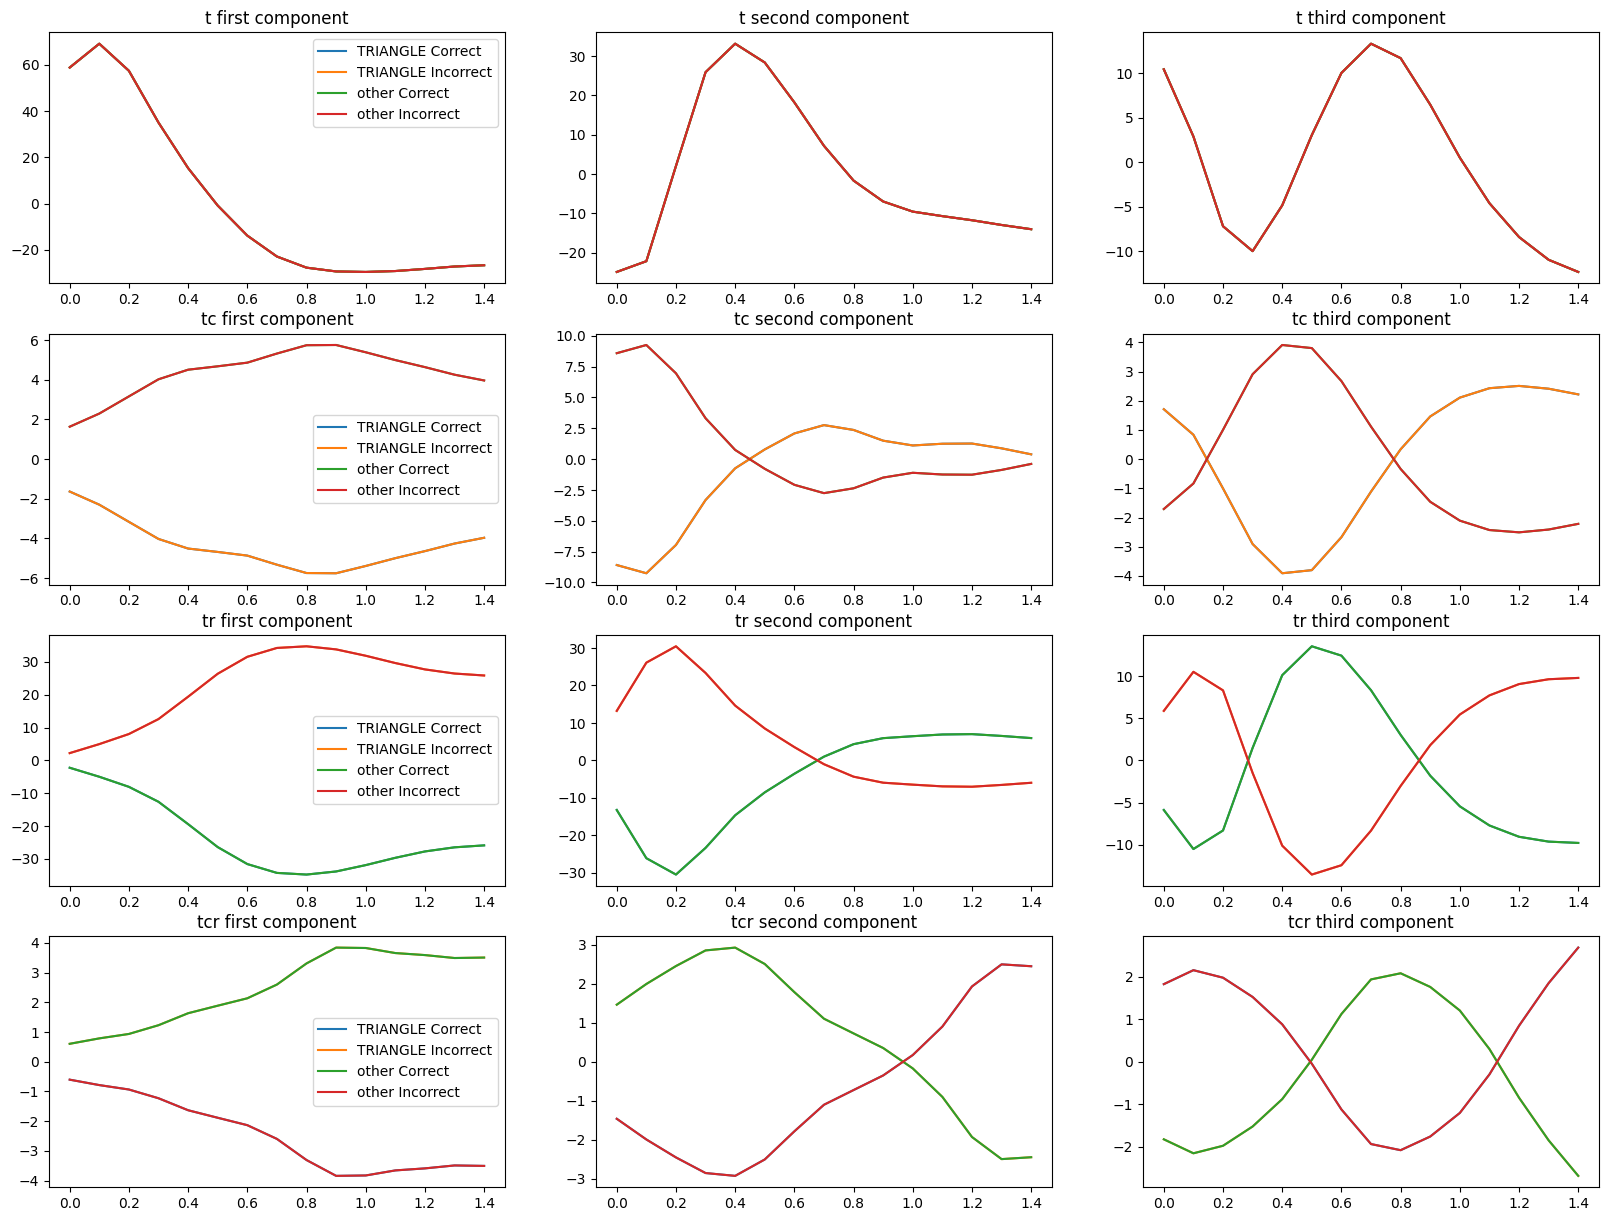

In [90]:
fig, axs = plt.subplots(len(res.keys()), 3, figsize=(20, 15))
x = np.arange(0, 1.5, 0.1)
for comp_idx, comp in enumerate(res):
    mat = res[comp]
    for choice_idx, choice in enumerate([feat, "other"]):
        for response_idx, response in enumerate(["Correct", "Incorrect"]):
            axs[comp_idx, 0].plot(x, mat[0, :, choice_idx, response_idx], label=f"{choice} {response}")
            axs[comp_idx, 1].plot(x, mat[1, :, choice_idx, response_idx], label=f"{choice} {response}")
            axs[comp_idx, 2].plot(x, mat[2, :, choice_idx, response_idx], label=f"{choice} {response}")

            axs[comp_idx, 0].legend()
            axs[comp_idx, 0].set_title(f"{comp} first component")
            axs[comp_idx, 1].set_title(f"{comp} second component")
            axs[comp_idx, 2].set_title(f"{comp} third component")

### Try to hand calc the anova factors...

In [28]:
total_var = np.sum(trial_averaged.FiringRate ** 2)
print(total_var)

222960.86361211672


subtract out time component first

In [29]:
time_mean = trial_averaged.groupby(["PseudoUnitID", "TimeBins"]).FiringRate.mean().reset_index(name="TimeMean")
time_subbed = pd.merge(trial_averaged, time_mean, on=["PseudoUnitID", "TimeBins"])
time_subbed["FiringRate"] = time_subbed.FiringRate - time_subbed.TimeMean

var = np.sum(time_subbed.FiringRate ** 2)
print(var)
print(var / total_var)

61810.727333559786
0.2772268026423302


Now go for response

In [30]:
response_mean = time_subbed.groupby(["PseudoUnitID", "TimeBins", "Response"]).FiringRate.mean().reset_index(name="ResponseMean")
response_subbed = pd.merge(time_subbed, response_mean, on=["PseudoUnitID", "TimeBins", "Response"])
response_subbed["FiringRate"] = response_subbed.FiringRate - response_subbed.ResponseMean

var = np.sum(response_subbed.FiringRate ** 2)
print(var)
print(var / total_var)

4023.1371770516116
0.01804414062573166


Finally choice

In [31]:
choice_mean = response_subbed.groupby(["PseudoUnitID", "TimeBins", "Choice"]).FiringRate.mean().reset_index(name="ChoiceMean")
choice_subbed = pd.merge(response_subbed, choice_mean, on=["PseudoUnitID", "TimeBins", "Choice"])
choice_subbed["FiringRate"] = choice_subbed.FiringRate - choice_subbed.ChoiceMean

var = np.sum(choice_subbed.FiringRate ** 2)
print(var)
print(var / total_var)

1125.7698911024327
0.00504918160462872


In [23]:
choice_subbed

,PseudoUnitID,TimeBins,FiringRate,Response,Choice,condition,TimeMean,ResponseMean,ChoiceMean
0,2018080600,1.8,0.006667,Correct,TRIANGLE,TRIANGLECorrect,2.854490,-0.218075,0.148944
1,2018080600,1.8,-0.006667,Incorrect,TRIANGLE,TRIANGLEIncorrect,2.854490,0.218075,0.148944
2,2018080600,1.8,-0.006667,Correct,other,otherCorrect,2.854490,-0.218075,-0.148944
3,2018080600,1.8,0.006667,Incorrect,other,otherIncorrect,2.854490,0.218075,-0.148944
4,2018080600,1.9,0.067860,Correct,TRIANGLE,TRIANGLECorrect,0.187418,-0.124437,0.372869
...,...,...,...,...,...,...,...,...,...
21175,2018061538,3.1,-0.010213,Incorrect,other,otherIncorrect,-0.124494,-0.130858,0.060162
21176,2018061538,3.2,-0.047018,Correct,TRIANGLE,TRIANGLECorrect,-0.010928,0.178207,-0.006003
21177,2018061538,3.2,0.047018,Incorrect,TRIANGLE,TRIANGLEIncorrect,-0.010928,-0.178207,-0.006003
21178,2018061538,3.2,0.047018,Correct,other,otherCorrect,-0.010928,0.178207,0.006003


### Choose 10 random units, plot firing rate by choice, response

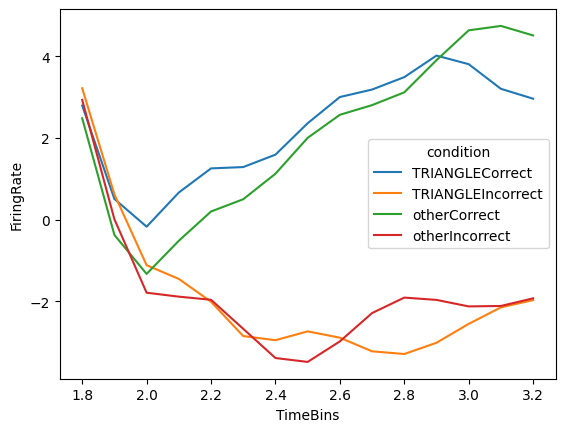

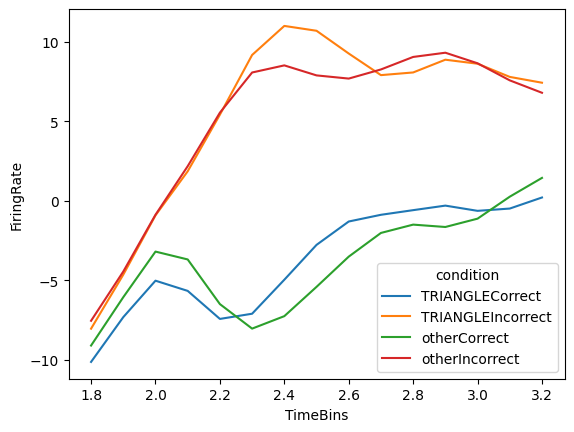

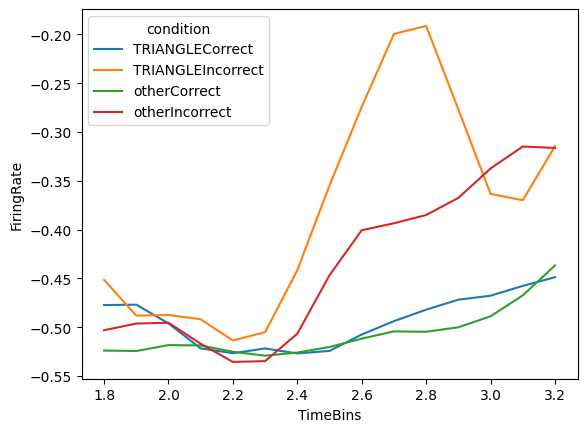

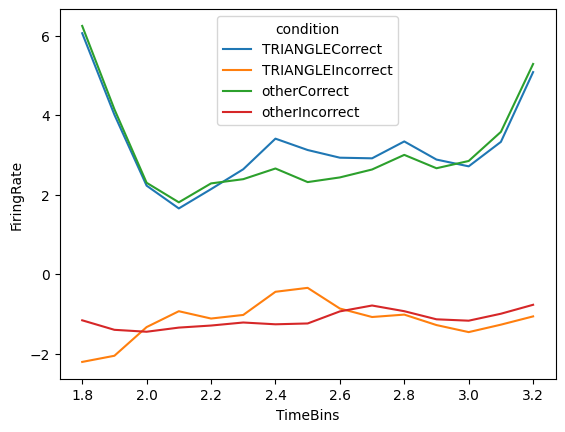

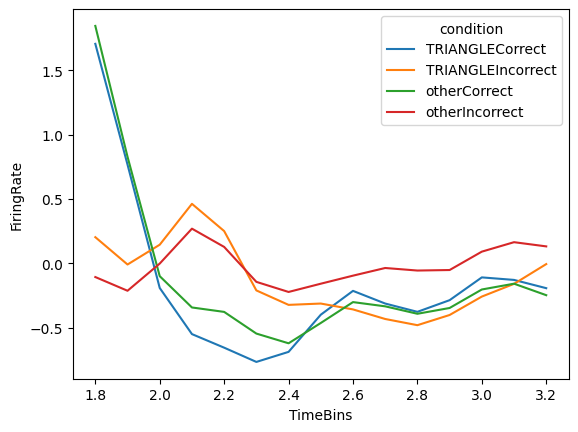

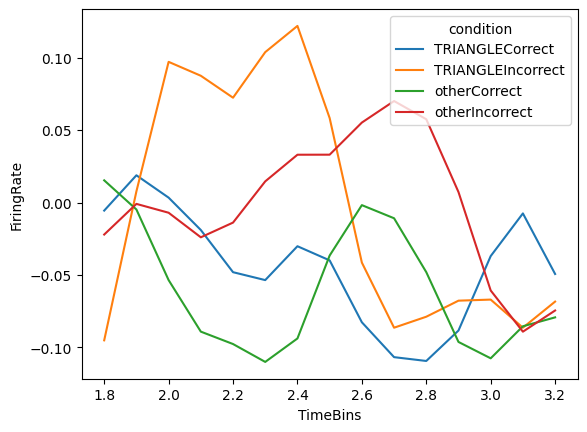

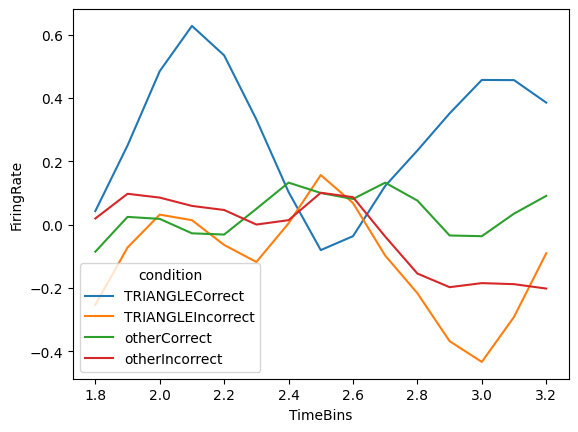

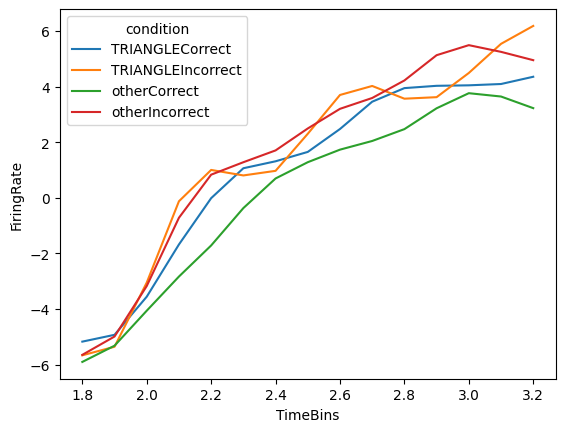

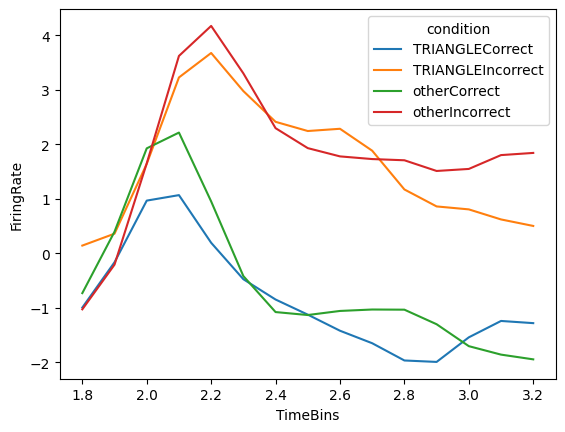

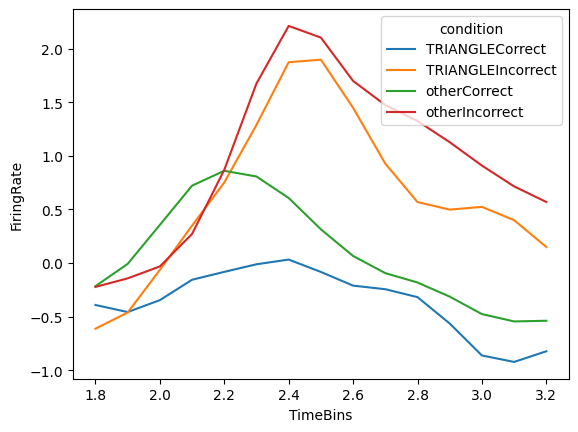

In [118]:
units = trial_averaged.PseudoUnitID.unique()
for unit in units[:10]:
    unit_ex = trial_averaged[trial_averaged.PseudoUnitID == unit]
    fig, ax = plt.subplots()
    sns.lineplot(unit_ex, x="TimeBins", y="FiringRate", hue="condition", ax=ax)